In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# loading the data
filename = 5  # options: 5 for old dataset - 6 for new
data = pd.read_csv(f'Data/queryResults0.{filename}.csv', low_memory=False)
data = data[data.columns.drop('icd_code')].drop_duplicates() if filename == 6 else data[data.columns.drop(['icd_code', 'SLP_time'])].drop_duplicates()
event_names = list(data.columns.drop(['subject_id', 'hadm_id', 'gender', 'anchor_age', 'stay_id', 'ICU_los']))

# extracting unique (patient id, admission id) pairs
patient_hadm = data[['subject_id', 'hadm_id']].drop_duplicates().sort_values('subject_id').reset_index(drop=True)

# extracting patient info, event names, and tdeltas for every unique pair above: 
sex_age = []
tdeltas = []
event_sequences = []
maximum_tdelta = 0
maximum_age = 0
for i in range(len(patient_hadm)):
    time_sequence = []
    event_sequence = []
    subsection = data[(data['subject_id'] == patient_hadm.iloc[i, 0]) & (data['hadm_id'] == patient_hadm.iloc[i, 1])]
    sex_age.append([subsection.iloc[0, 2], subsection.iloc[0, 3]]) # storing the gender and the age
    if maximum_age < subsection.iloc[0, 3]:
        maximum_age = subsection.iloc[0, 3]
    for ename in event_names:
        for j in range(len(subsection[ename].drop_duplicates().values)):
            event_sequence.append(ename)
            time_sequence.append(subsection[ename].drop_duplicates().values[j])
    df = pd.DataFrame(zip(event_sequence, time_sequence))
    df[0] = df[0].astype(str)
    df[1] = df[1].astype('datetime64[ns]')
    df = df.sort_values(by=1).dropna()
    df[2] = 1e-12
    for j in range(1, len(df)):
        df.iloc[j, 2] = (df.iloc[j, 1] - df.iloc[j-1, 1]).value*1e-9
    if maximum_tdelta < df[2].max():
        maximum_tdelta = df[2].max()
    tdeltas.append(list(df[2]))
    event_sequences.append(list(df[0]))

# truncating outliers (tdeltas more than 30 days are removed)
td = []
ev = []
sa = []
for i, rec in enumerate(tdeltas):
    if (np.array(rec) < 86400*30).all():
        td.append(rec)
        ev.append(event_sequences[i])
        sa.append(sex_age[i])
tdeltas = td
event_sequences = ev
sex_age = sa

# encoding events
encoding = {'ED_intime': 0, 'ED_outtime': 1, 'CT_time': 2, 'SW_time': 3, 'TPA_time': 4, 'admission_time': 5,
            'discharge_time': 6, 'ICU_intime': 7, 'ICU_outtime': 8, 'SLP_time': 9}
for i in range(len(event_sequences)):
    event_sequences[i] = [encoding[event_sequences[i][j]] for j in range(len(event_sequences[i]))]

# sequence length adjustments
l4_indices = [i for i in range(len(event_sequences)) if len(event_sequences[i]) > 4]
event_sequences4 = [event_sequences[i] for i in l4_indices]
tdeltas4 = [tdeltas[i] for i in l4_indices]
sage4 = [sex_age[i] for i in l4_indices]

l6_indices = [i for i in range(len(event_sequences)) if len(event_sequences[i]) > 6]
event_sequences6 = [event_sequences[i] for i in l6_indices]
tdeltas6 = [tdeltas[i] for i in l6_indices]
sage6 = [sex_age[i] for i in l6_indices]

l8_indices = [i for i in range(len(event_sequences)) if len(event_sequences[i]) > 8]
event_sequences8 = [event_sequences[i] for i in l8_indices]
tdeltas8 = [tdeltas[i] for i in l8_indices]
sage8 = [sex_age[i] for i in l8_indices]

# measuring max sequence length
maximum_sequence_length = 0
for i in range(len(event_sequences)):
    if len(event_sequences[i]) > maximum_sequence_length:
        maximum_sequence_length = len(event_sequences[i])
# max sequence length is 37 (1st phase)
# max sequence length is ? (2nd phase)

print(f"Max sequence length = {maximum_sequence_length}")
print(f"Max time delta = {2591683} seconds.")
print(f"Max age = {maximum_age}")

print("="*50)
print(f"Total number of records = {len(event_sequences)}")
print(f"Number of records with length of more than 4 = {len(event_sequences4)}")
print(f"Number of records with length of more than 6 = {len(event_sequences6)}")
print(f"Number of records with length of more than 8 = {len(event_sequences8)}")

# saving the unpadded sequences
def save(data_name):
    joblib.dump([event_sequences,  tdeltas,  sex_age],  f"PreparedData/_raw_{data_name}_full_sequences.pkl")
    joblib.dump([event_sequences4, tdeltas4, sage4], f"PreparedData/_raw_{data_name}_4+_sequences.pkl")
    joblib.dump([event_sequences6, tdeltas6, sage6], f"PreparedData/_raw_{data_name}_6+_sequences.pkl")
    joblib.dump([event_sequences8, tdeltas8, sage8], f"PreparedData/_raw_{data_name}_8+_sequences.pkl")

# if filename == 5:
#     save("old")
# else:
#     save("new")

Max sequence length = 37
Max time delta = 2591683 seconds.
Max age = 91
Total number of records = 12210
Number of records with length of more than 4 = 1911
Number of records with length of more than 6 = 1573
Number of records with length of more than 8 = 768


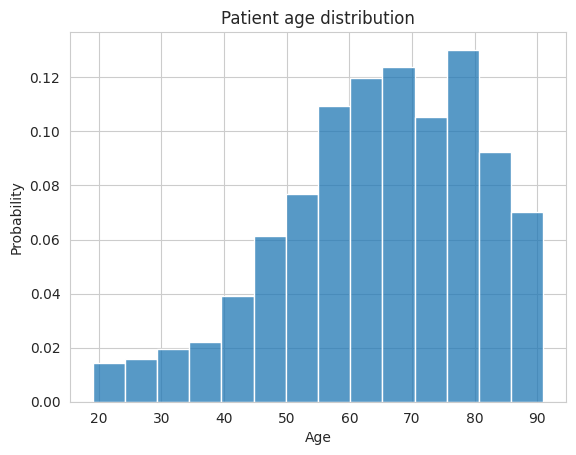

In [9]:
ages = pd.DataFrame(sex_age)[1]
plt.figure()
plt.grid(zorder=0)
plt.title("Patient age distribution")
plt.xlabel("Age")
sns.histplot(ages, binwidth=5, stat='probability', zorder=2);

In [115]:
# age range: 20-91
# bins = 20-25, 25-30, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90-95
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
bin_counts = np.histogram(np.array(ages), bins=np.arange(start=20, stop=96, step=5))[0]
bin_probs = bin_counts/bin_counts.sum()
print(bins)
print(bin_probs)

[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[0.00344149 0.00516224 0.00811209 0.00999672 0.01655195 0.03105539
 0.0483448  0.07276303 0.10660439 0.13430023 0.13413635 0.13798755
 0.13356277 0.0950508  0.06293019]


In [26]:
male = (pd.DataFrame(sex_age)[0] == 'M').sum()/len(sex_age)
print(f"Male percentage = {male*100:.1f}%, female percentage = {(1 - male)*100:.1f}%")

Male percentage = 52.6%, female percentage = 47.4%


In [33]:
first_events = np.array([events[0] for events in event_sequences])
ed_ratio = (first_events == 0).sum()/first_events.shape[0]
print(f"ED start percentage = {ed_ratio*100:.1f}%, Admission start percentage = {(1 - ed_ratio)*100:.1f}%")

ED start percentage = 72.5%, Admission start percentage = 27.5%


In [7]:
# loading saved data
def load(sequence_size=None):
    if sequence_size is None:
        event_sequences, tdeltas, sex_age = joblib.load("PreparedData/_raw_old_full_sequences.pkl")
    elif sequence_size == 4:
        event_sequences, tdeltas, sex_age = joblib.load("PreparedData/_raw_old_4+_sequences.pkl")
    elif sequence_size == 6:
        event_sequences, tdeltas, sex_age = joblib.load("PreparedData/_raw_old_6+_sequences.pkl")
    else:
        event_sequences, tdeltas, sex_age = joblib.load("PreparedData/_raw_old_8+_sequences.pkl")
    return event_sequences, tdeltas, sex_age

# =========================================================================================================
sequence_size = None  # (full=)None , 4, 6, 8
event_sequences, tdeltas, sex_age = load(sequence_size=sequence_size)

# extracting subsequences + (input, target) pairs
# measuring max sequence length
maximum_sequence_length = 0
for i in range(len(event_sequences)):
    if len(event_sequences[i]) > maximum_sequence_length:
        maximum_sequence_length = len(event_sequences[i])

# padding event and tdelta sequences
def extract(event_seq, time_deltas, sex_age):
    xevents = []
    xtds = []
    yevents = []
    ytds = []
    sex = []
    age = []
    for i in range(len(event_seq)):
        for j in range(1, len(event_seq[i])+1):
            xevents.append(event_seq[i][:j] + [6]*(maximum_sequence_length - j))             # padding with discharge time (code=6)
            yevents.append(event_seq[i][j]) if j != len(event_seq[i]) else yevents.append(6)
            xtds.append([1e-12] + time_deltas[i][1:j] + [0]*(maximum_sequence_length - j))   # padding with tdelta=0
            ytds.append(time_deltas[i][j]) if j != len(time_deltas[i]) else ytds.append(0)
            sex.append(sex_age[i][0])
            age.append(sex_age[i][1])
    return xevents, xtds, yevents, np.array(ytds), sex, age

xevent_sequences, xtdeltas, yevent_sequences, ytdeltas, sex, age = extract(event_sequences, tdeltas, sex_age)
print(f"Number of records after extraction = {len(xevent_sequences)}")

# onehot encoding
ohe = OneHotEncoder(categories=[list(range(9)), ], sparse_output=False)
onehot_events = ohe.fit_transform(np.array(xevent_sequences)[:, 0].reshape(-1, 1))
for i in range(1, 37):
    onehot_events = np.c_[onehot_events, ohe.transform(np.array(xevent_sequences)[:, i].reshape(-1, 1))]
x= pd.concat([pd.DataFrame(age)/91, pd.get_dummies(pd.DataFrame(sex)), pd.DataFrame(onehot_events), pd.DataFrame(xtdeltas)/600000], axis=1)
yevent_sequences = ohe.transform(np.array(yevent_sequences).reshape(-1, 1))
x = (x*1).astype(np.float64)

def final_save(sequence_size):
    joblib.dump([x.to_numpy(), yevent_sequences, ytdeltas/600000], f"PreparedData/x_eventy_tdeltay_{'full' if sequence_size is None else str(sequence_size)+'+'}.pkl")
    
# final_save(sequence_size)

"""
Patient age is the first column in x. 
The next 2 columns are the one hot encoded version of the patient's sex. 
The next 9*37=351 columns are one-hot encoded versions of the event codes.
the next 37 columns are the normalized values of the tdeltas.
Consequently, the total number of columns is 373.
""";
# todo: there are numerous icu out events after discharge time. check if this is correct.

Number of records after extraction = 8825


In [59]:
x

,0,0_F,0_M,0,1,2,3,4,5,6,...,27,28,29,30,31,32,33,34,35,36
0,0.802198,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.802198,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.802198,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.802198,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.802198,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8820,0.692308,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8821,0.692308,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8822,0.692308,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8823,0.692308,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
